# Exercise 2

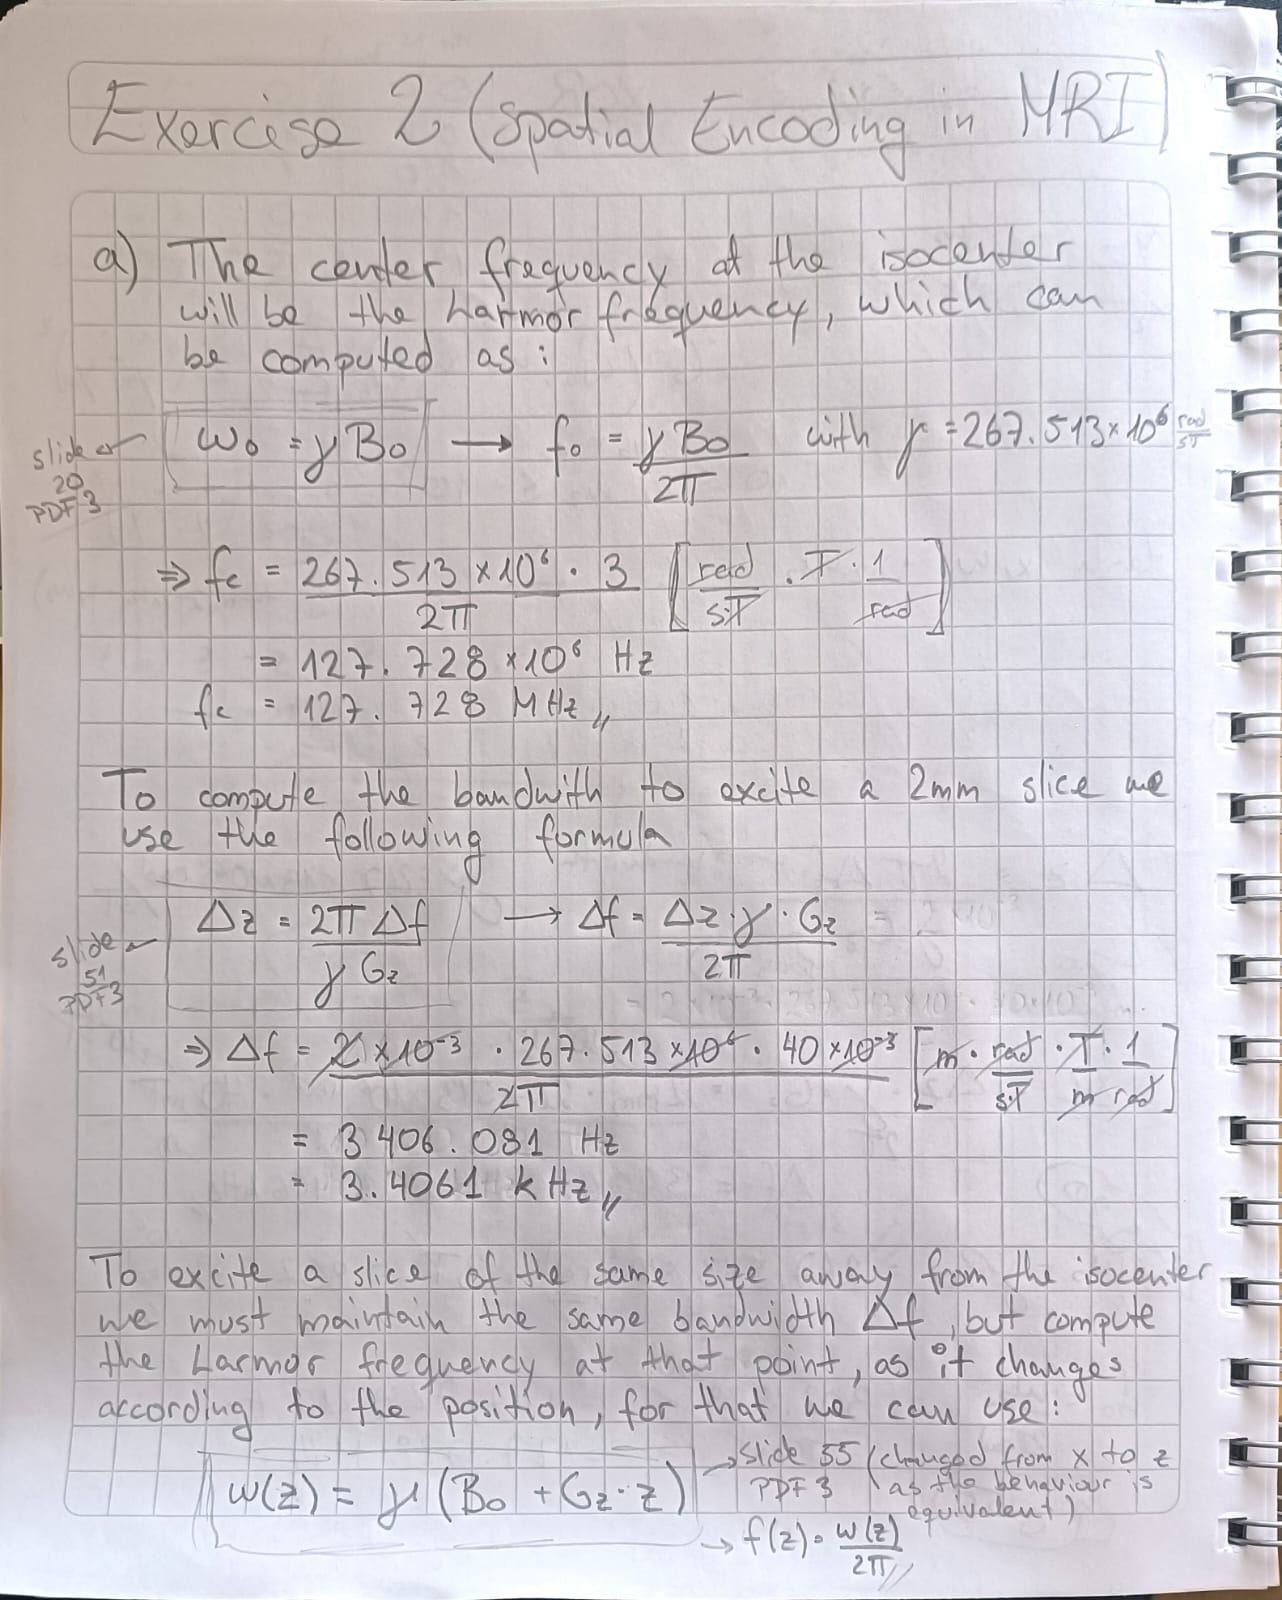

In [2]:
from PIL import Image
from IPython.display import display
img = Image.open('IAAN_A2_Ex2a.jpeg')
display(img,)

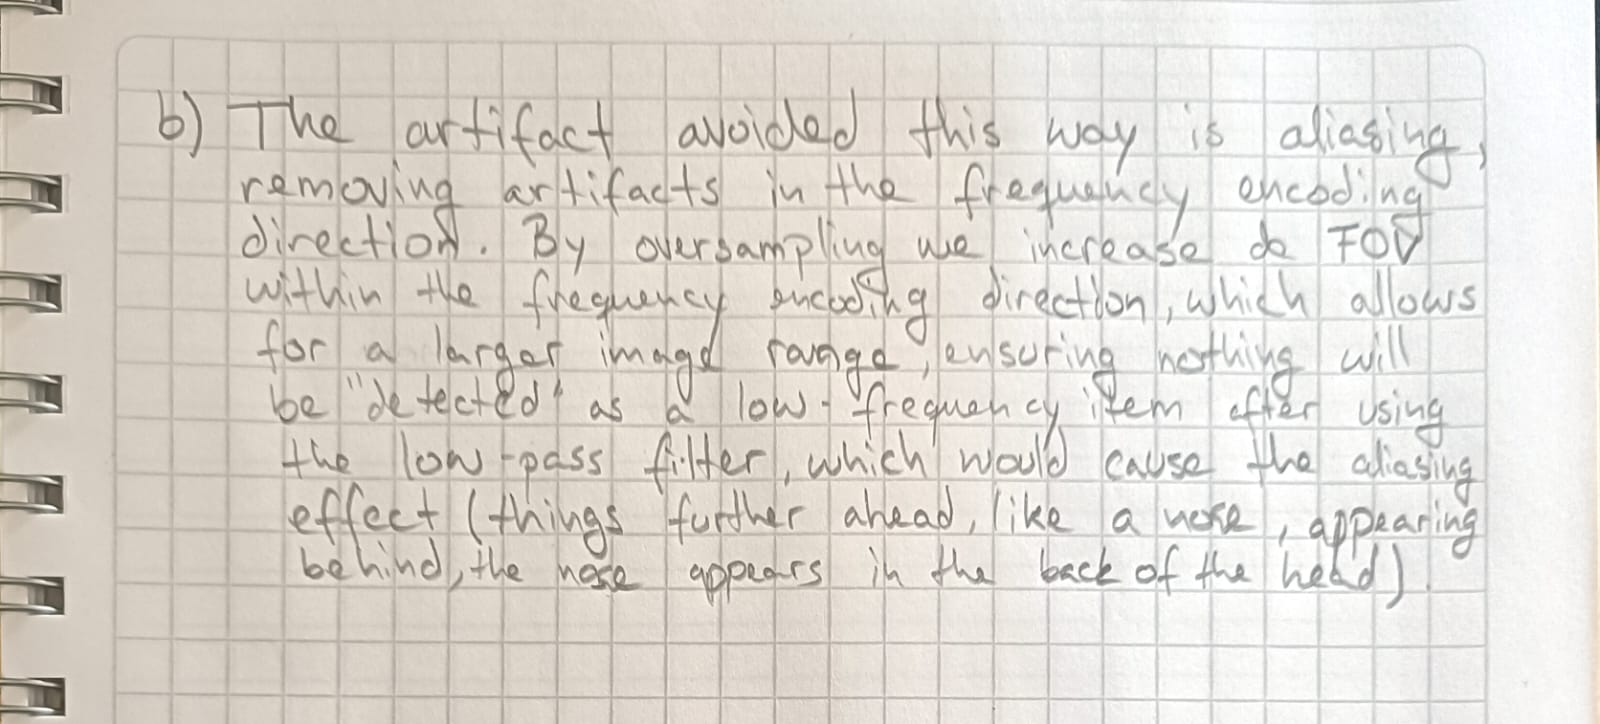

In [3]:
img = Image.open('IAAN_A2_Ex2b.jpeg')
display(img)

# Exercise 3

### a)

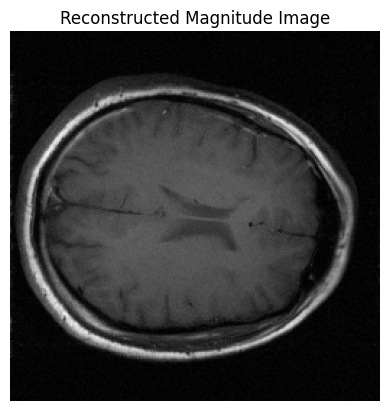

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load and Reformat k-space Data ---

# Define the file name
filename = 'mrimage1d.txt'


# Read the text file, flatten it, and 'view' pairs of floats as complex numbers
kspace_data = np.loadtxt(filename).ravel().view(complex).reshape((256, 256))

# --- 2. Reconstruct the Image ---

# The canonical MR reconstruction pipeline:
# 1. np.fft.ifftshift: Undo the "centered" k-space. Moves the center
#    (low frequencies) from (128,128) to the corner (0,0) for the FFT algorithm.
# 2. np.fft.ifft2: Perform the 2D Inverse Fourier Transform.
# 3. np.fft.fftshift: Center the resulting image. Moves the image's
#    center (which is at the corner (0,0) after ifft2) back to (128,128).

img_complex = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace_data)))

# --- 3. Visualize the Magnitude Image ---

# Get the magnitude (absolute value) of the complex image
img_magnitude = np.abs(img_complex)

# Display the image
plt.imshow(img_magnitude, cmap='gray')
plt.title('Reconstructed Magnitude Image')
plt.axis('off') # Hide the x and y axes
plt.show()

### b)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


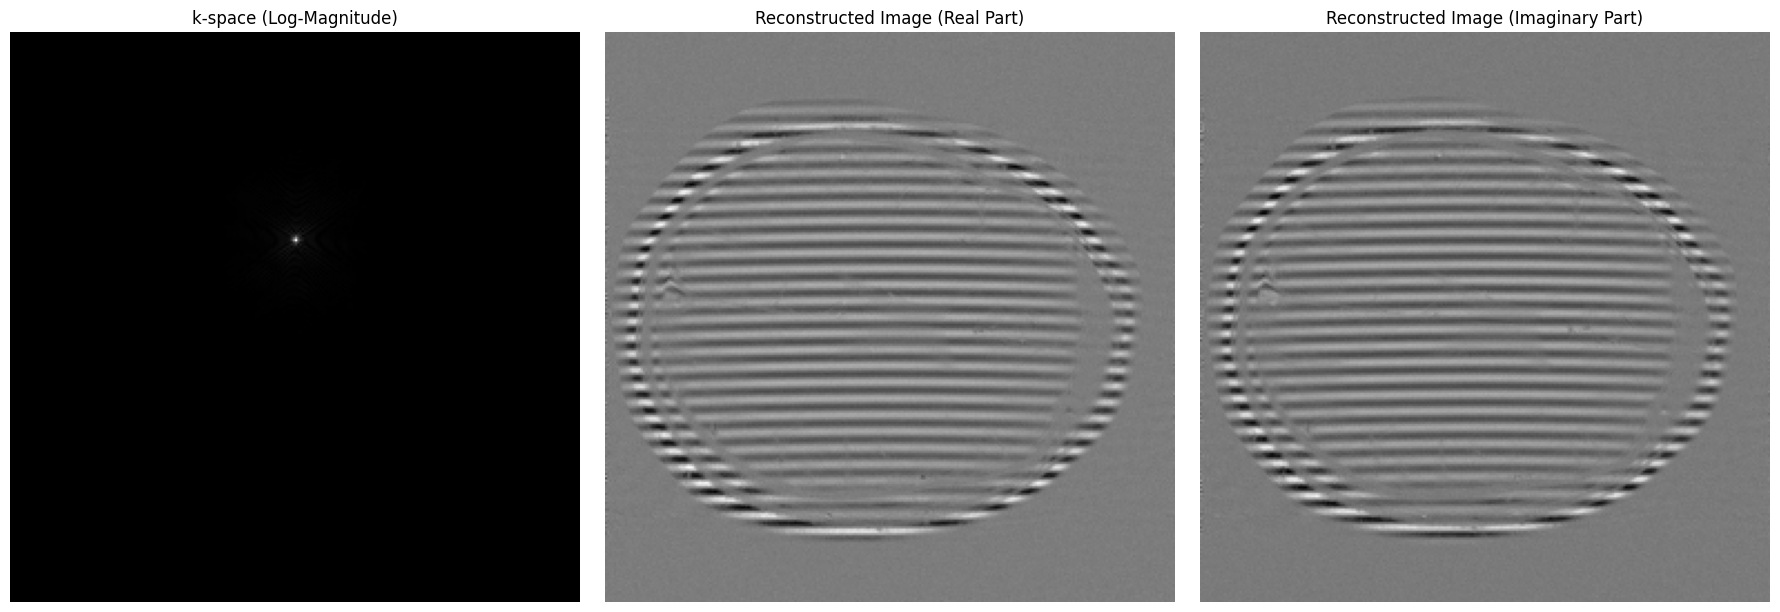

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#2. Prepare Data for Visualization

# k-space: Log-magnitude.
# We use np.log1p(x) which calculates log(1+x)
# This handles x=0 gracefully (log(1)=0) and scales the view.
kspace_log_mag = np.log1p(np.abs(kspace_data))

#Image: Separate real and imaginary parts
img_real = np.real(img_complex)
img_imag = np.imag(img_complex)

#3. Visualize All Three

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Log-Magnitude k-space
ax1.imshow(kspace_log_mag, cmap='gray')
ax1.set_title('k-space (Log-Magnitude)')
ax1.axis('off')

# Plot 2: Real part of the image
ax2.imshow(img_real, cmap='gray')
ax2.set_title('Reconstructed Image (Real Part)')
ax2.axis('off')

# Plot 3: Imaginary part of the image
ax3.imshow(img_imag, cmap='gray')
ax3.set_title('Reconstructed Image (Imaginary Part)')
ax3.axis('off')

plt.tight_layout()
plt.savefig('my_reconstruction.png')
plt.show()

k-space Visualization (Frequency Domain)
Yes, the k-space spectrum is centered as expected. 
The first plot shows that the highest-magnitude (brightest) values, which represent the low-frequency components of the image, are located in the center of the 256x256 matrix. 
The magnitudes decay as you move outward toward the high-frequency edges.

Image Visualization (Spatial Domain)
Yes, the reconstructed image is real-valued.

Spatial-Frequency Connection
This observation is a direct consequence of a fundamental property of the Fourier Transform:
A real-valued signal in the spatial domain (the image) must correspond to a frequency-domain signal (k-space) that has conjugate symmetry.

Our k-space log-magnitude plot visually confirms this centrosymmetry (it would look the same if rotated 180 degrees). Because the measured k-space data has this property, the inverse Fourier transform (our reconstruction) results in an image that is real-valued, with all the meaningful information captured in the real component.

### C)

Reconstructed image saved as epi_reconstruction_zigzag.png


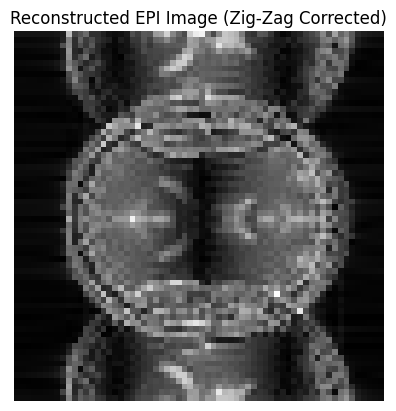

In [4]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'sepi.npy'

# 1. Load the data
raw_data = np.load(filename)

# 2. Reshape the data
# Reshape the 1D vector of 4096 points into a 2D (64, 64) k-space matrix
kspace = raw_data.reshape((64, 64))

# 3. Correct for EPI zig-zag
# We apply the correction to a copy to be safe
kspace_corrected = kspace.copy()

# Select every other row (1, 3, 5, ...)
# Reverse the order of elements in that row (::-1)
# Take the complex conjugate
kspace_corrected[1::2] = np.conjugate(kspace_corrected[1::2, ::-1])

# 4. Reconstruct the image
# Standard MR reconstruction pipeline:
# 1. Move k-space center to corner for FFT
# 2. 2D Inverse FFT
# 3. Move image center from corner back to center
img_complex = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace_corrected)))

# 5. Visualize the magnitude
img_magnitude = np.abs(img_complex)

plt.imshow(img_magnitude, cmap='gray')
plt.title('Reconstructed EPI Image (Zig-Zag Corrected)')
plt.axis('off')

# Save the image
output_filename = 'epi_reconstruction_zigzag.png'
plt.savefig(output_filename)
print(f"Reconstructed image saved as {output_filename}")

### d)

--- Part 1: Finding Sub-pixel Shift ---
Positive echo peak: 29.2804
Negative echo peak: 31.5014
Calculated shift:   -2.2210 samples


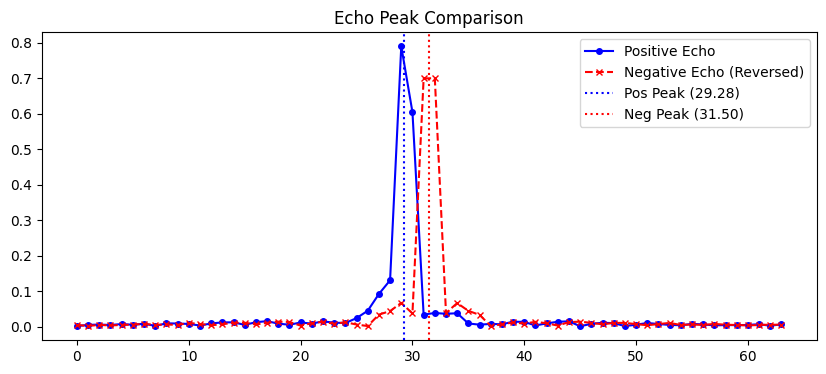


 Part 2: Applying Correction to Image
Applying -2.2210 sample shift to odd k-space lines...
Applying global phase correction of 2.8420 radians...


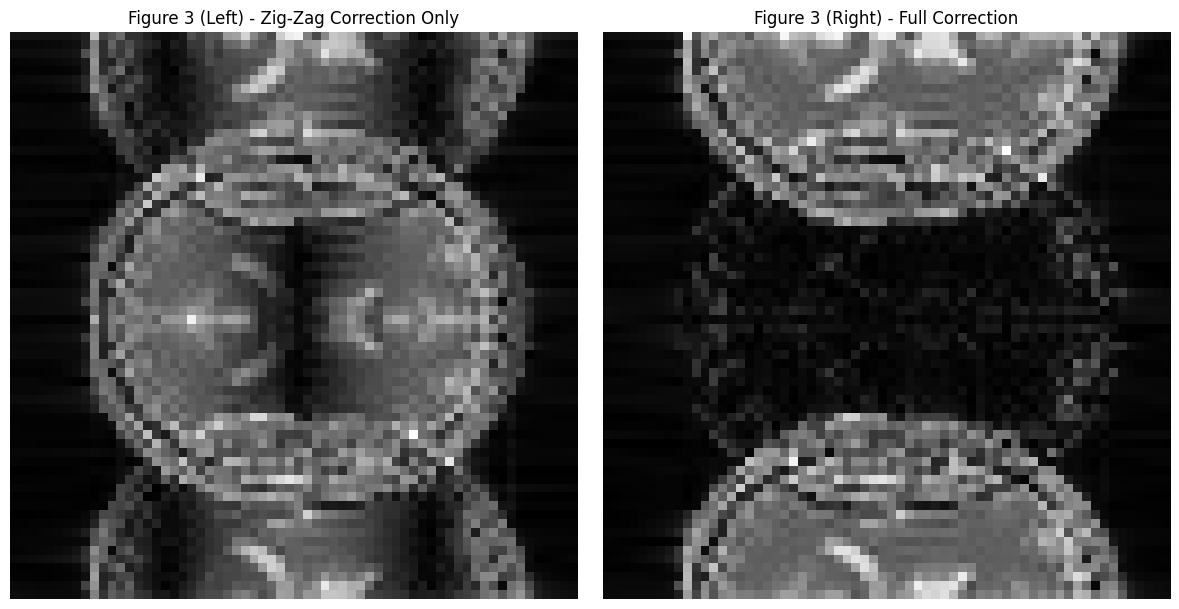

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift

def find_subpixel_peak_shift(spc_file):
    print("--- Part 1: Finding Sub-pixel Shift ---")
    
    # --- 1. Load and process echo data ---
    spc_data = np.load(spc_file)
    # First 64 points are the positive echo
    echo_pos = spc_data[:64]
    # Second 64 points are the negative echo, which is time-reversed
    echo_neg_rev = spc_data[64:][::-1]

    # --- 2. Find sub-pixel peak locations ---
    def get_peak(data):
        """Finds sub-pixel peak by fitting a parabola to the max point."""
        peak_idx = np.argmax(np.abs(data))
        # Get 3 points around the peak for the fit
        y_points = np.abs(data[peak_idx-1 : peak_idx+2])
        # Fit y = ax^2 + bx + c to x = [-1, 0, 1]
        poly = np.polyfit([-1, 0, 1], y_points, 2)
        # The vertex (max) of the parabola is at x = -b / (2a)
        offset = -poly[1] / (2 * poly[0])
        return peak_idx + offset

    peak_pos = get_peak(echo_pos)
    peak_neg = get_peak(echo_neg_rev)
    
    # The shift to apply to the negative echo to align it with the positive one
    pixel_shift = peak_pos - peak_neg

    print(f"Positive echo peak: {peak_pos:.4f}")
    print(f"Negative echo peak: {peak_neg:.4f}")
    print(f"Calculated shift:   {pixel_shift:.4f} samples")

    # --- 3. Plot the echoes ---
    plt.figure(figsize=(10, 4))
    plt.title('Echo Peak Comparison')
    plt.plot(np.abs(echo_pos), 'b-o', label='Positive Echo', markersize=4)
    plt.plot(np.abs(echo_neg_rev), 'r--x', label='Negative Echo (Reversed)', markersize=4)
    # Plot vertical lines at calculated peaks
    plt.axvline(peak_pos, color='b', linestyle=':', label=f'Pos Peak ({peak_pos:.2f})')
    plt.axvline(peak_neg, color='r', linestyle=':', label=f'Neg Peak ({peak_neg:.2f})')
    plt.legend()
    plt.show()
    
    return pixel_shift

def correct_epi_image(sepi_file, pixel_shift):
    print("\n Part 2: Applying Correction to Image")

    #1. Load and apply initial zig-zag correction
    kspace = np.load(sepi_file).reshape((64, 64))
    
    #Create a copy for the uncorrected "before" image
    kspace_zigzag_corr = kspace.copy()
    kspace_zigzag_corr[1::2] = np.conjugate(kspace_zigzag_corr[1::2, ::-1])

    #Create a second copy for the "after" image
    kspace_shifted = kspace_zigzag_corr.copy()

    #2. Apply sub-pixel shift correction
    # We apply the calculated shift to the odd-numbered lines (the negative echoes)
    # using cubic interpolation (order=3).
    print(f"Applying {pixel_shift:.4f} sample shift to odd k-space lines...")
    for i in range(1, 64, 2):
        # We shift the complex data. scipy's shift handles this.
        kspace_shifted[i, :] = shift(kspace_shifted[i, :], 
                                     shift=pixel_shift, 
                                     order=3, 
                                     mode='constant', 
                                     cval=0.0)

    #3. Apply phase correction
    # We force the k-space center (DC component) to be real.
    # This removes a global, arbitrary phase offset.
    # The center of our 64x64 *centered* k-space is at (32, 32).
    center_phase = np.angle(kspace_shifted[32, 32])
    print(f"Applying global phase correction of {-center_phase:.4f} radians...")
    kspace_final = kspace_shifted * np.exp(-1j * center_phase)

    #4. Reconstruct both images for comparison
    # "Before" image (only zig-zag)
    img_before = np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace_zigzag_corr))))
    
    # "After" image (full correction)
    img_after = np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace_final))))

    #5. Display results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img_before, cmap='gray')
    ax1.set_title('Figure 3 (Left) - Zig-Zag Correction Only')
    ax1.axis('off')

    ax2.imshow(img_after, cmap='gray')
    ax2.set_title('Figure 3 (Right) - Full Correction')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

#Main execution
# Part 1: Find the shift
shift_to_apply = find_subpixel_peak_shift('spc.npy')

# Part 2: Apply the shift
correct_epi_image('sepi.npy', shift_to_apply)